In [1]:
import torch, torchvision
torch.__version__, torchvision.__version__

('2.0.0+cu118', '0.15.1+cu118')

In [2]:
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [3]:
from timeit import default_timer as timer

#### Getting torchvision dataset
`torchvision` provides some datasets that we can import to train our models. Here, we will use FashionMNIST dataset for demonstration. The returned variable is of type `Dataset` and has both features and the label of the sample at each index of the dataset.

In [4]:
train_data = torchvision.datasets.FashionMNIST(root="data",
                                               train=True, # download only training dataset
                                               download=True,
                                               transform=torchvision.transforms.ToTensor(),
                                               target_transform=None)

test_data = torchvision.datasets.FashionMNIST(root="data",
                                               train=False, # download only test dataset
                                               download=True,
                                               transform=torchvision.transforms.ToTensor(),
                                               target_transform=None)

In [5]:
first_image, first_targe_label = train_data[0]
first_image.shape, first_targe_label

(torch.Size([1, 28, 28]), 9)

In [6]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1ed919a3820>,
 <torch.utils.data.dataloader.DataLoader at 0x1ed919a3850>)

Let's see how to interact with the dataloader. As mentioned before, `DataLoader` turns our dataset into a Python iterable.

In [7]:
len(train_dataloader), len(test_dataloader)

(938, 157)

In [8]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch

(torch.Size([64, 1, 28, 28]),
 tensor([7, 5, 2, 7, 4, 0, 9, 0, 3, 2, 5, 0, 7, 5, 2, 9, 1, 6, 6, 7, 6, 4, 9, 3,
         8, 0, 8, 5, 2, 6, 8, 8, 3, 3, 3, 1, 3, 3, 4, 5, 0, 8, 4, 8, 0, 8, 0, 9,
         1, 7, 5, 0, 7, 8, 2, 0, 2, 3, 1, 8, 7, 1, 9, 1]))

Turns out, the `DataLoader` class converts the torchvision dataset features into the shape of B x C x H x W.

#### Build a fully-connected network.
Here, we will attempt to make classification of images based on fully-connected layers only. Also note, that we have not added non-linear activation functions here.

In [9]:
class FashionMNIST_classifier(torch.nn.Module):

    def __init__(self, input_shape: int, hidden_units : int, output_shape : int):
        super().__init__()
        self.seq_layer_stack = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=input_shape, out_features=hidden_units),
            torch.nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x : torch.Tensor) -> torch.Tensor:
        return self.seq_layer_stack(x)


#### Training
Train the network using `DataLoader` object. The training loop algorithm looks as below:<br>
- Loop through epochs.
    - for training batch 0 to ...
        - calculate `training_loss` for this batch using loss function.
        - calculate gradients using `loss.backward()`.
        - update parameters using `optimizer.step()`.
    - for testing batch 0 to ...
        - calculate `test_loss` for this batch.
        

In [10]:
from helper_functions import accuracy_fn

from tqdm import tqdm



from utils import print_training_time

In [11]:
len(train_dataloader)

938

Checking output format before training.


In [12]:
# create a classifier.
# shape of a FashionMNIST image is 28*28 and there are 10 different output labels.
torch.manual_seed(42)
_classifier = FashionMNIST_classifier(input_shape=28*28, hidden_units=10, output_shape=10)
_classifier = _classifier.to(device="cpu")

with torch.inference_mode():
    for batch_num, (X, y) in enumerate(train_dataloader):
        y_pred_batch = _classifier(X)
        break
# check the shape of the batch output
y_pred_batch.shape

torch.Size([64, 10])

In [13]:
# create a classifier.
# shape of a FashionMNIST image is 28*28 and there are 10 different output labels.
torch.manual_seed(42)
classifier = FashionMNIST_classifier(input_shape=28*28, hidden_units=10, output_shape=10)
classifier = classifier.to(device="cpu")

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params= classifier.parameters(), lr= 0.1)

epochs = 5
epochs_ctr = []
avg_tr_loss_per_batch_list = []
avg_tr_acc_per_batch_list = []
avg_test_loss_per_batch_list = []
avg_test_acc_per_batch_list = []



for epoch in tqdm(range(0, epochs)):
    
    epoch_training_time_start = timer()

    print("\nEpoch ", epoch)
    epochs_ctr.append(epoch)
    cumulative_training_loss_per_epoch = 0
    cumulative_tr_acc_per_epoch = 0

    # training
    classifier.train()
    for batch_num, (X, y) in enumerate(train_dataloader):
        
        y_pred_batch = classifier(X)

        batch_loss = loss_function(y_pred_batch, y)
        tr_acc = accuracy_fn(y, y_pred_batch.argmax(dim = 1))
        cumulative_tr_acc_per_epoch += tr_acc
        
        # accumulate training loss for an epoch for plotting purpose
        # ensure to detach the variable value from the computation graph
        cumulative_training_loss_per_epoch += batch_loss.item()

        # wipe out garbage gradients accumulated
        optimizer.zero_grad()

        # backpropagation to calculate gradients
        batch_loss.backward()

        # optimizer the model parameters once per batch
        optimizer.step()
      
    
    # average training loss per batch
    avg_tr_loss_per_batch = cumulative_training_loss_per_epoch/len(train_dataloader)
    avg_tr_acc_per_batch = cumulative_tr_acc_per_epoch/len(train_dataloader)



    # store average loss and accuracy for plot
    avg_tr_loss_per_batch_list.append(avg_tr_loss_per_batch)
    avg_tr_acc_per_batch_list.append(avg_tr_acc_per_batch)

    

    # testing
    classifier.eval()
    with torch.inference_mode():

        cumulative_test_loss_per_epoch = 0
        cumulative_test_acc_per_epoch = 0

        for batch_num, (X,y) in enumerate(test_dataloader):

            test_preds = classifier(X)
            test_loss = loss_function(test_preds, y)
            cumulative_test_loss_per_epoch += test_loss.item()

            test_acc = accuracy_fn(y, test_preds.argmax(dim = 1))
            cumulative_test_acc_per_epoch += test_acc
        
        # calculate average test loss and test accuracy per batch
        avg_test_loss_per_batch = cumulative_test_loss_per_epoch/len(test_dataloader)
        avg_test_acc_per_batch = cumulative_test_acc_per_epoch/len(test_dataloader)
        
        # store average loss and accuracy for plot
        avg_test_loss_per_batch_list.append(avg_test_loss_per_batch)
        avg_test_acc_per_batch_list.append(avg_test_acc_per_batch)

    # print each epoch
    print("Avg tr loss/ batch:", round(avg_tr_loss_per_batch, 3), "Avg training acc/batch:", round(avg_tr_acc_per_batch, 3),\
           "Avg test loss/batch:", round(avg_test_loss_per_batch,3),"Average test acc/batch:", round(avg_test_acc_per_batch,3))

    # calculate epoch training time
    epoch_training_end_time = timer()
    total_training_time = print_training_time(start=epoch_training_time_start, end=epoch_training_end_time, device=str(next(classifier.parameters())))


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch  0


 20%|██        | 1/5 [00:10<00:40, 10.08s/it]

Avg tr loss/ batch: 0.632 Avg training acc/batch: 78.078 Avg test loss/batch: 0.583 Average test acc/batch: 78.971
Epoch training time: 10.081 seconds.

Epoch  1


 40%|████      | 2/5 [00:21<00:33, 11.07s/it]

Avg tr loss/ batch: 0.482 Avg training acc/batch: 82.974 Avg test loss/batch: 0.57 Average test acc/batch: 80.623
Epoch training time: 11.757 seconds.

Epoch  2


 60%|██████    | 3/5 [00:33<00:22, 11.12s/it]

Avg tr loss/ batch: 0.456 Avg training acc/batch: 84.014 Avg test loss/batch: 0.471 Average test acc/batch: 83.191
Epoch training time: 11.173 seconds.

Epoch  3


 80%|████████  | 4/5 [00:44<00:11, 11.14s/it]

Avg tr loss/ batch: 0.443 Avg training acc/batch: 84.533 Avg test loss/batch: 0.465 Average test acc/batch: 83.499
Epoch training time: 11.166 seconds.

Epoch  4


100%|██████████| 5/5 [00:59<00:00, 11.97s/it]

Avg tr loss/ batch: 0.435 Avg training acc/batch: 84.845 Avg test loss/batch: 0.473 Average test acc/batch: 82.952
Epoch training time: 15.665 seconds.


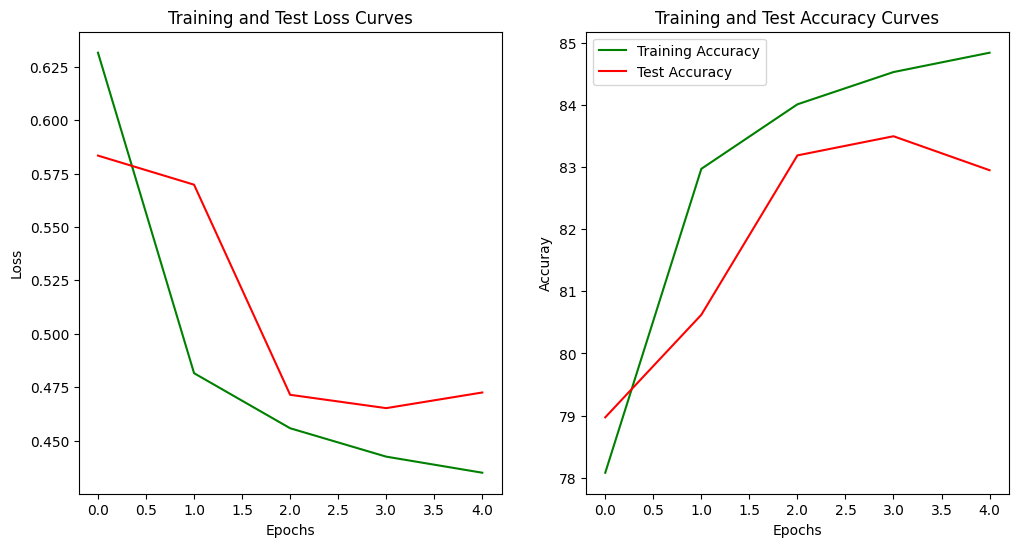

In [14]:
plt.figure(figsize=(12,6))

# subplot 1
plt.subplot(1,2,1) 
plt.title("Loss")
plt.plot(epochs_ctr, avg_tr_loss_per_batch_list, "g", label = "Training Loss")
plt.plot(epochs_ctr, avg_test_loss_per_batch_list, "r", label = "Test Loss")
plt.title("Training and Test Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# subplot 2
plt.subplot(1,2,2)
plt.title("Test")
plt.title("Accuracy")
plt.plot(epochs_ctr, avg_tr_acc_per_batch_list, "g", label = "Training Accuracy")
plt.plot(epochs_ctr, avg_test_acc_per_batch_list, "r", label = "Test Accuracy")
plt.title("Training and Test Accuracy Curves")
plt.xlabel("Epochs")
plt.ylabel("Accuray")

plt.legend()
plt.show()

As seen above, with the learning rate 0.1, the performance flattens pretty quick. The final performance is nowhere near perfect. It would be interesting to see if the performance would get better with a smaller learning rate and a more number of epochs.

In [15]:
# create a classifier.
# shape of a FashionMNIST image is 28*28 and there are 10 different output labels.
torch.manual_seed(42)
classifier = FashionMNIST_classifier(input_shape=28*28, hidden_units=10, output_shape=10)
classifier = classifier.to(device="cpu")

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params= classifier.parameters(), lr= 0.005)

epochs = 20
epochs_ctr = []
avg_tr_loss_per_batch_list = []
avg_tr_acc_per_batch_list = []
avg_test_loss_per_batch_list = []
avg_test_acc_per_batch_list = []



for epoch in tqdm(range(0, epochs)):
    
    epoch_training_time_start = timer()

    print("\nEpoch ", epoch)
    epochs_ctr.append(epoch)
    cumulative_training_loss_per_epoch = 0
    cumulative_tr_acc_per_epoch = 0

    # training
    classifier.train()
    for batch_num, (X, y) in enumerate(train_dataloader):
        
        y_pred_batch = classifier(X)

        batch_loss = loss_function(y_pred_batch, y)
        tr_acc = accuracy_fn(y, y_pred_batch.argmax(dim = 1))
        cumulative_tr_acc_per_epoch += tr_acc
        
        # accumulate training loss for an epoch for plotting purpose
        # ensure to detach the variable value from the computation graph
        cumulative_training_loss_per_epoch += batch_loss.item()

        # wipe out garbage gradients accumulated
        optimizer.zero_grad()

        # backpropagation to calculate gradients
        batch_loss.backward()

        # optimizer the model parameters once per batch
        optimizer.step()
      
    
    # average training loss per batch
    avg_tr_loss_per_batch = cumulative_training_loss_per_epoch/len(train_dataloader)
    avg_tr_acc_per_batch = cumulative_tr_acc_per_epoch/len(train_dataloader)



    # store average loss and accuracy for plot
    avg_tr_loss_per_batch_list.append(avg_tr_loss_per_batch)
    avg_tr_acc_per_batch_list.append(avg_tr_acc_per_batch)

    

    # testing
    classifier.eval()
    with torch.inference_mode():

        cumulative_test_loss_per_epoch = 0
        cumulative_test_acc_per_epoch = 0

        for batch_num, (X,y) in enumerate(test_dataloader):

            test_preds = classifier(X)
            test_loss = loss_function(test_preds, y)
            cumulative_test_loss_per_epoch += test_loss.to("cpu").item()

            test_acc = accuracy_fn(y, test_preds.argmax(dim = 1))
            cumulative_test_acc_per_epoch += test_acc
        
        # calculate average test loss and test accuracy per batch
        avg_test_loss_per_batch = cumulative_test_loss_per_epoch/len(test_dataloader)
        avg_test_acc_per_batch = cumulative_test_acc_per_epoch/len(test_dataloader)
        
        # store average loss and accuracy for plot
        avg_test_loss_per_batch_list.append(avg_test_loss_per_batch)
        avg_test_acc_per_batch_list.append(avg_test_acc_per_batch)

    # print each epoch
    print("Avg tr loss/ batch:", round(avg_tr_loss_per_batch, 3), "Avg training acc/batch:", round(avg_tr_acc_per_batch, 3),\
           "Avg test loss/batch:", round(avg_test_loss_per_batch,3),"Average test acc/batch:", round(avg_test_acc_per_batch,3))

    # calculate epoch training time
    epoch_training_end_time = timer()
    total_training_time = print_training_time(start=epoch_training_time_start, end=epoch_training_end_time, device=str(next(classifier.parameters())))


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch  0


  5%|▌         | 1/20 [00:12<03:58, 12.55s/it]

Avg tr loss/ batch: 1.475 Avg training acc/batch: 57.086 Avg test loss/batch: 0.958 Average test acc/batch: 68.332
Epoch training time: 12.549 seconds.

Epoch  1


 10%|█         | 2/20 [00:25<03:52, 12.90s/it]

Avg tr loss/ batch: 0.82 Avg training acc/batch: 72.776 Avg test loss/batch: 0.759 Average test acc/batch: 73.955
Epoch training time: 13.143 seconds.

Epoch  2


 15%|█▌        | 3/20 [00:39<03:48, 13.42s/it]

Avg tr loss/ batch: 0.692 Avg training acc/batch: 76.714 Avg test loss/batch: 0.675 Average test acc/batch: 76.851
Epoch training time: 14.031 seconds.

Epoch  3


 20%|██        | 4/20 [00:53<03:37, 13.57s/it]

Avg tr loss/ batch: 0.627 Avg training acc/batch: 79.003 Avg test loss/batch: 0.628 Average test acc/batch: 78.404
Epoch training time: 13.812 seconds.

Epoch  4


 25%|██▌       | 5/20 [01:07<03:23, 13.57s/it]

Avg tr loss/ batch: 0.586 Avg training acc/batch: 80.319 Avg test loss/batch: 0.595 Average test acc/batch: 79.598
Epoch training time: 13.55 seconds.

Epoch  5


 30%|███       | 6/20 [01:20<03:09, 13.56s/it]

Avg tr loss/ batch: 0.558 Avg training acc/batch: 81.247 Avg test loss/batch: 0.571 Average test acc/batch: 80.583
Epoch training time: 13.558 seconds.

Epoch  6


 35%|███▌      | 7/20 [01:34<02:58, 13.76s/it]

Avg tr loss/ batch: 0.537 Avg training acc/batch: 81.898 Avg test loss/batch: 0.552 Average test acc/batch: 81.16
Epoch training time: 14.166 seconds.

Epoch  7


 40%|████      | 8/20 [01:48<02:46, 13.84s/it]

Avg tr loss/ batch: 0.521 Avg training acc/batch: 82.294 Avg test loss/batch: 0.543 Average test acc/batch: 81.369
Epoch training time: 14.009 seconds.

Epoch  8


 45%|████▌     | 9/20 [02:02<02:30, 13.69s/it]

Avg tr loss/ batch: 0.509 Avg training acc/batch: 82.691 Avg test loss/batch: 0.532 Average test acc/batch: 81.568
Epoch training time: 13.358 seconds.

Epoch  9


 50%|█████     | 10/20 [02:15<02:16, 13.63s/it]

Avg tr loss/ batch: 0.499 Avg training acc/batch: 82.942 Avg test loss/batch: 0.52 Average test acc/batch: 81.996
Epoch training time: 13.48 seconds.

Epoch  10


 55%|█████▌    | 11/20 [02:29<02:02, 13.58s/it]

Avg tr loss/ batch: 0.49 Avg training acc/batch: 83.212 Avg test loss/batch: 0.517 Average test acc/batch: 81.947
Epoch training time: 13.471 seconds.

Epoch  11


 60%|██████    | 12/20 [02:43<01:50, 13.84s/it]

Avg tr loss/ batch: 0.482 Avg training acc/batch: 83.394 Avg test loss/batch: 0.51 Average test acc/batch: 82.136
Epoch training time: 14.447 seconds.

Epoch  12


 65%|██████▌   | 13/20 [02:56<01:35, 13.70s/it]

Avg tr loss/ batch: 0.476 Avg training acc/batch: 83.575 Avg test loss/batch: 0.504 Average test acc/batch: 82.265
Epoch training time: 13.364 seconds.

Epoch  13


 70%|███████   | 14/20 [03:10<01:21, 13.65s/it]

Avg tr loss/ batch: 0.471 Avg training acc/batch: 83.794 Avg test loss/batch: 0.499 Average test acc/batch: 82.335
Epoch training time: 13.527 seconds.

Epoch  14


 75%|███████▌  | 15/20 [03:24<01:08, 13.71s/it]

Avg tr loss/ batch: 0.466 Avg training acc/batch: 83.994 Avg test loss/batch: 0.494 Average test acc/batch: 82.952
Epoch training time: 13.836 seconds.

Epoch  15


 80%|████████  | 16/20 [03:41<00:58, 14.60s/it]

Avg tr loss/ batch: 0.461 Avg training acc/batch: 84.14 Avg test loss/batch: 0.493 Average test acc/batch: 82.773
Epoch training time: 16.689 seconds.

Epoch  16


 85%|████████▌ | 17/20 [03:54<00:42, 14.33s/it]

Avg tr loss/ batch: 0.457 Avg training acc/batch: 84.248 Avg test loss/batch: 0.491 Average test acc/batch: 82.912
Epoch training time: 13.679 seconds.

Epoch  17


 90%|█████████ | 18/20 [04:11<00:30, 15.21s/it]

Avg tr loss/ batch: 0.454 Avg training acc/batch: 84.4 Avg test loss/batch: 0.484 Average test acc/batch: 83.081
Epoch training time: 17.277 seconds.

Epoch  18


 95%|█████████▌| 19/20 [04:29<00:15, 15.83s/it]

Avg tr loss/ batch: 0.45 Avg training acc/batch: 84.493 Avg test loss/batch: 0.489 Average test acc/batch: 82.494
Epoch training time: 17.253 seconds.

Epoch  19


100%|██████████| 20/20 [04:45<00:00, 14.26s/it]

Avg tr loss/ batch: 0.447 Avg training acc/batch: 84.567 Avg test loss/batch: 0.476 Average test acc/batch: 83.26
Epoch training time: 16.036 seconds.


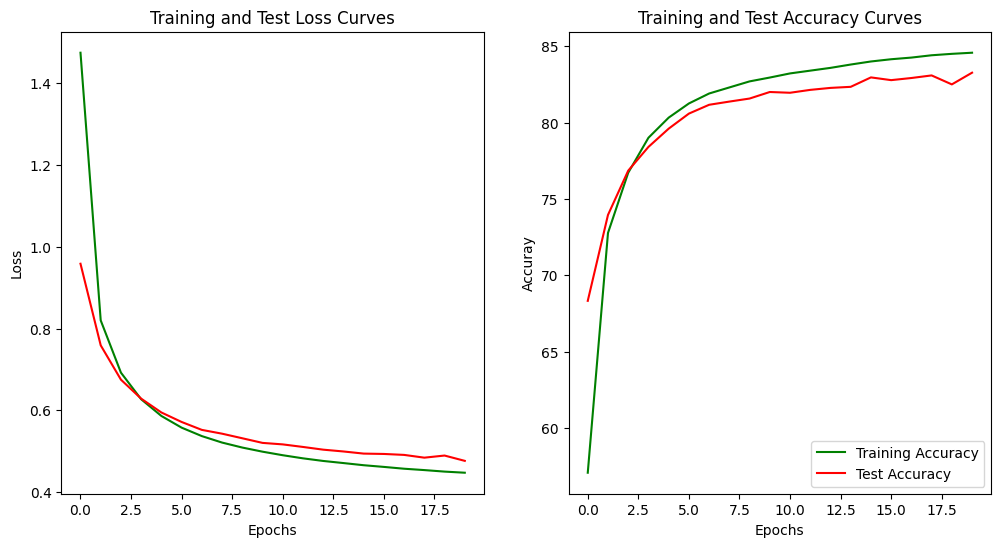

In [16]:
plt.figure(figsize=(12,6))

# subplot 1
plt.subplot(1,2,1) 
plt.title("Loss")
plt.plot(epochs_ctr, avg_tr_loss_per_batch_list, "g", label = "Training Loss")
plt.plot(epochs_ctr, avg_test_loss_per_batch_list, "r", label = "Test Loss")
plt.title("Training and Test Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# subplot 2
plt.subplot(1,2,2)
plt.title("Test")
plt.title("Accuracy")
plt.plot(epochs_ctr, avg_tr_acc_per_batch_list, "g", label = "Training Accuracy")
plt.plot(epochs_ctr, avg_test_acc_per_batch_list, "r", label = "Test Accuracy")
plt.title("Training and Test Accuracy Curves")
plt.xlabel("Epochs")
plt.ylabel("Accuray")

plt.legend()
plt.show()

As seen above, the performance flatten at around 85% accuracy on test data and the training time per epoch oscillates around 13 seconds. Can we do better in these two metrics?<br>
- Notice that we have not used non-linear activations in the models used above. They are definitely helpful in increasing the accuracy since they allow for non-linear boundaries as seen in a previous notebook.
- Notice that we have trained the model above using CPU. Next notebook will be on reducing training time by leveraging the available GPU.